In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import os
import sys 
import random 

# Load image and template


In [2]:
image_path = "Counting/cat.jpg"
template__folder_path = os.path.join("match_template", image_path[:-4])
template__folder_path

'match_template\\Counting/cat'

In [3]:
def get_template(folder_path: str):
    templates = []
    for file in os.listdir(folder_path):
        template = cv2.imread(os.path.join(folder_path, file))
        templates.append(template)
    return templates



In [4]:
def plot_image(image: np.array, title: str= "", type: str="rgb"):
    if type == "gray":
        plt.imshow(image, cmap="gray")
    else: 
        plt.imshow(image[:, :, ::-1])
    plt.title(title)
    plt.show()  

In [5]:
templates = get_template(template__folder_path)


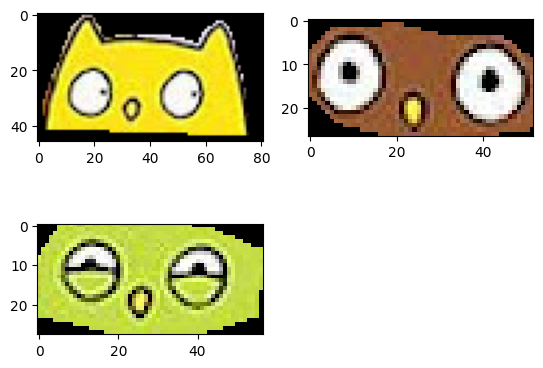

In [6]:
for idx in range(len(templates)):
    plt.subplot(2, 2, idx + 1)
    img = templates[idx]
    # print(img)
    plt.imshow(templates[idx][:, :, ::-1])

In [7]:
image_rgb = cv2.imread(image_path)

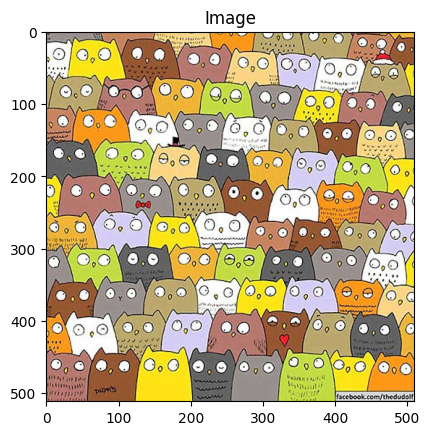

In [8]:
plot_image(image_rgb, "Image")

# Convert to gray

In [9]:
templates_gray = [cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) for template in templates]
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)


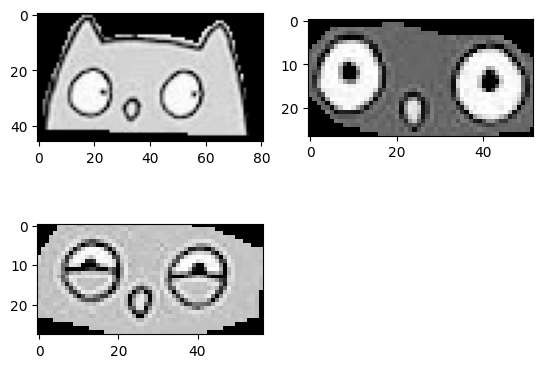

In [10]:
for idx in range(len(templates_gray)):
    plt.subplot(2, 2, idx + 1)
    img = templates_gray[idx]
    # print(img)
    plt.imshow(templates_gray[idx], cmap="gray")

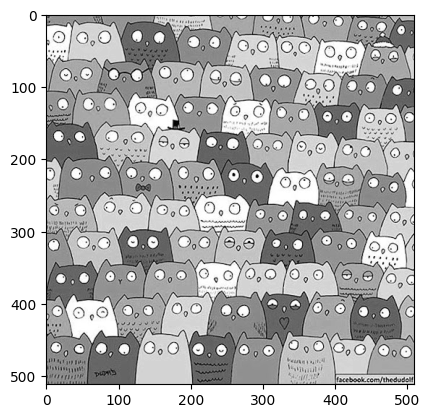

In [11]:
plt.imshow(image_gray, cmap="gray")

# Processing

In [12]:
def eliminate_color(image: np.array):
    """
    Input: gray image 
    
    Output: binary image
    
    Process: 
    detect edge using canny edge detection
    revert the color of the edge
    thresholding
    """
    edges = cv2.Canny(image, 127, 255)
    edges = cv2.GaussianBlur(255 - edges, (3, 3), 0)
    # edges = 255 - edges
    _, binary_img = cv2.threshold(edges, 240, 255, cv2.THRESH_BINARY)
    
    return binary_img
    

In [13]:
processed_image = eliminate_color(image_gray)

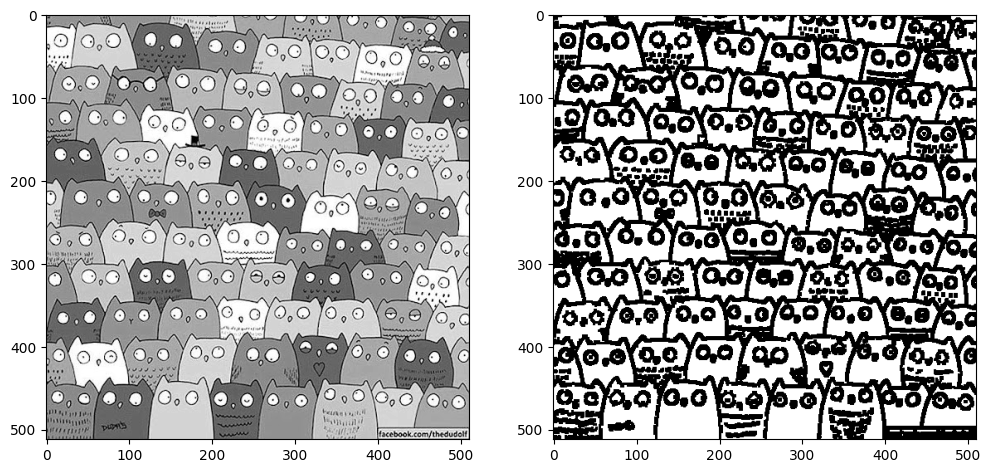

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(image_gray, cmap="gray")

plt.subplot(122)
plt.imshow(processed_image, cmap="gray")

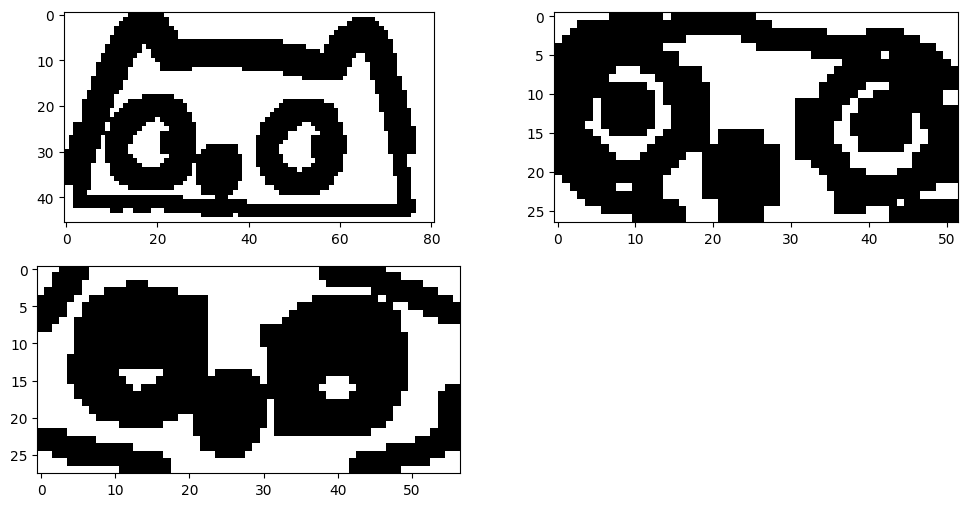

In [15]:
processed_template = [eliminate_color(template) for template in templates_gray]
plt.figure(figsize=(12, 6))
for idx in range(len(processed_template)):
    plt.subplot(2, 2, idx + 1)
    plt.imshow(processed_template[idx], cmap="gray")

# Template matching

In [16]:
def check_overlap(box1, box2, overlap_threshold=0.5):
    """
    Input:
    box1: Tuple (x1, y1, w1, h1) of the first bounding box
    box2: Tuple (x2, y2, w2, h2) of the second bounding box
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return False
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate the area of the first bounding box
    box1_area = w1 * h1
    
    # Calculate the overlap ratio
    overlap_ratio = intersection_area / box1_area
    
    # Return True if the overlap ratio is greater than or equal to the threshold
    return overlap_ratio >= overlap_threshold

In [17]:
def find_bounding_boxs(image: np.array, templates: np.array, selecting_threshold: float=0.95, plot_match_map: bool=False, title: str=""):
    check = [] 
    if plot_match_map:
        plt.figure(figsize=(12, 6))
        plt.title(title)
    for idx in range(len(templates)): 
        # print(template.shape)
        template = templates[idx]
        h, w = template.shape
        res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
        if plot_match_map:
            plt.subplot(3, 3, idx + 1)
            plt.imshow(res, cmap="gray")
            
        
        # res = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)
        
        if selecting_threshold > 0 and selecting_threshold < 1: 
            threshold = sorted(res.flatten())[int(0.95 * len(res.flatten()))]
        else:
            threshold = sorted(res.flatten())[selecting_threshold]
        loc = np.where(res >= threshold)
        
        x, y = loc[::-1]  
        for i in range(len(x)):
            score = res[y[i], x[i]]
            check.append((score, x[i], y[i], w, h))
        
    return check
    

In [18]:
# res = cv2.matchTemplate(image_gray, templates_gray[1], cv2.TM_CCOEFF_NORMED)
# threshold = sorted(res.flatten())[int(0.99 * len(res.flatten()))]
# loc = np.where(res >= threshold)
# x, y = loc[::-1]  
# res_image = image_rgb.copy()
# w, h = templates_gray[0].shape[::-1]
# for bb in zip(*loc[::-1]):
#     cv2.rectangle(res_image, bb, (bb[0] + w, bb[1] +h), (0,0,255), 2)
# plt.imshow(res_image[:, :, ::-1])

In [38]:
def apply_templates(image, templates, original_image= None, 
                    plot_processed_image= True, binary_convert = True, 
                    selecting_threshold= 0.95, overlap_threshold=0.5,
                    plot_match_map= False, bounding_box_threshold=0.7):
    """
    Input: 
    image: gray image 
    templates: list of gray templates
    """
    def plot(images, title= ""):
        if isinstance(images, list):
            plt.figure(figsize=(12, 6))
            for idx in range(len(images)):
                plt.subplot(3, 3, idx + 1)
                plt.imshow(images[idx], cmap="gray")
                plt.title(title)
            plt.show()
        else:
            plt.imshow(images, cmap="gray")
            plt.title(title)
            plt.show()
    ## get all possible bounding boxes
    bboxes = []
    bboxes.extend(find_bounding_boxs(image, templates, selecting_threshold, plot_match_map= plot_match_map, title= "Gray Templates"))
    if binary_convert:
        processed_image = eliminate_color(image)
        proceseed_templates = [eliminate_color(template) for template in templates]
        bboxes.extend(find_bounding_boxs(processed_image, proceseed_templates, selecting_threshold, plot_match_map= plot_match_map, title= "Binary Templates"))
        
        if plot_processed_image:
            plot([image, processed_image], "Original and Processed Image")
            plot(templates, title= "Gray Templates")
            plot(proceseed_templates, title= "Processed Templates")
    else:
        plot(image, "Original Image")
    

    # sort the bounding boxes 
    check = sorted(bboxes, key=lambda x: x[0], reverse=True)
    # print(len(check))
    
    # bb_res = [] 
    # for i in range(len(check)):
    #     x1, y1, w1, h1 = check[i][1:]
    #     if len(bb_res) == 0:
    #         bb_res.append((x1, y1, w1, h1))
    #     else:
    #         flag = True
    #         for box in bb_res:
    #             if check_overlap(box, (x1, y1, w1, h1), overlap_threshold):
    #                 flag = False
    #                 break
    #         if flag:
    #             bb_res.append((x1, y1, w1, h1))
    bb_res = []
    for i in range(len(check)):
        if len(bb_res) == 0:
            bb_res.append(check[i])
        else:
            flag = True
            for box in bb_res:
                if check_overlap(box[1:], check[i][1:], overlap_threshold):
                    flag = False
                    break
            if flag:
                bb_res.append(check[i])
    mean_score = np.mean([x[0] for x in bb_res])
    print("lowest score: ", bb_res[-1][0])
    print("highest score: ", bb_res[0][0])
    print("mean score: ", mean_score)
    score_threshold = bb_res[int(bounding_box_threshold * len(bb_res))][0]
    print("score threshold: ", score_threshold)
    bb_res = [x for x in bb_res if x[0] > score_threshold]
    bb_res = [x[1:] for x in bb_res]
    if original_image is not None:
        res_image = original_image.copy()
        for bb in bb_res:
            cv2.rectangle(res_image, bb[:2], (bb[0] + bb[2], bb[1] + bb[3]), (0,0,255), 2)
        plt.imshow(res_image[:, :, ::-1])
    return bb_res
    

lowest score:  0.13265972
highest score:  0.88033074
mean score:  0.36398745
score threshold:  0.2863536


75

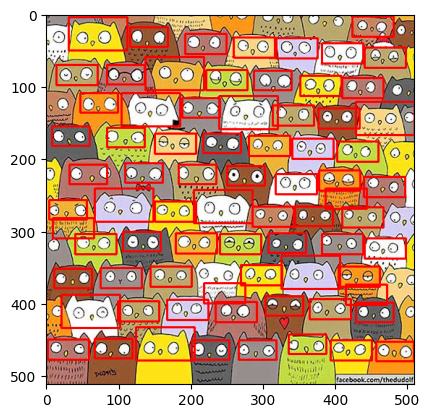

In [41]:
bb= apply_templates(image_gray,templates_gray,original_image= image_rgb, plot_processed_image= False, selecting_threshold= 0.95,
                    overlap_threshold= 0.1, plot_match_map= False, binary_convert= True, bounding_box_threshold= 0.68)
len(bb)

lowest score:  0.13265972
highest score:  0.88033074
mean score:  0.36398745
score threshold:  0.20682038


88

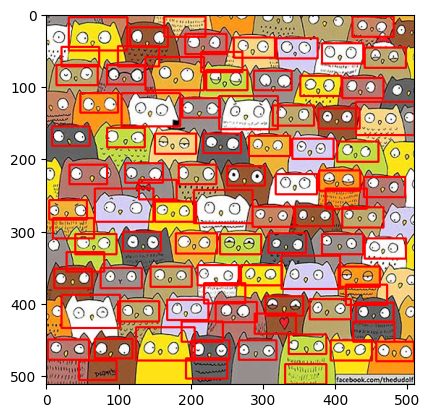

In [34]:
bb= apply_templates(image_gray,templates_gray,original_image= image_rgb, plot_processed_image= False, selecting_threshold= 0.95,
                    overlap_threshold= 0.1, plot_match_map= False)
len(bb)

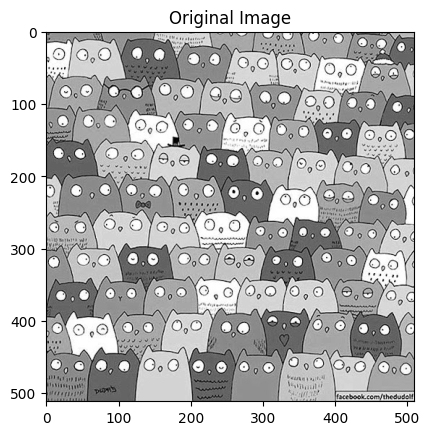

lowest score:  0.17920287
highest score:  0.88033074
mean score:  0.31404102
score threshold:  0.23452316


75

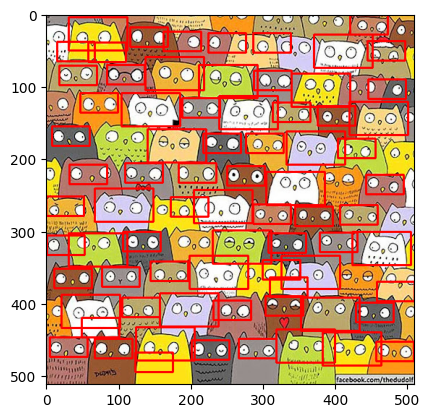

In [31]:
bb= apply_templates(image_gray,templates_gray[:2],original_image= image_rgb, binary_convert= False, overlap_threshold= 0.2)
len(bb)

83

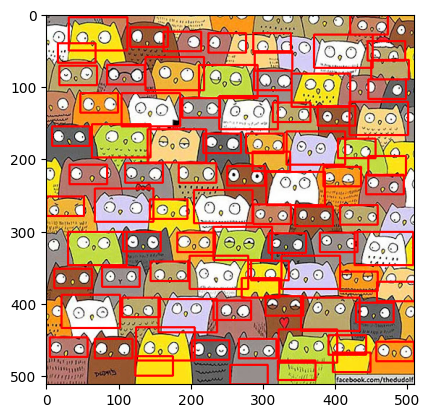

In [133]:
a = apply_templates(image_gray, templates_gray[:2], image_rgb,overlap_threshold=0.1)
len(a)

95

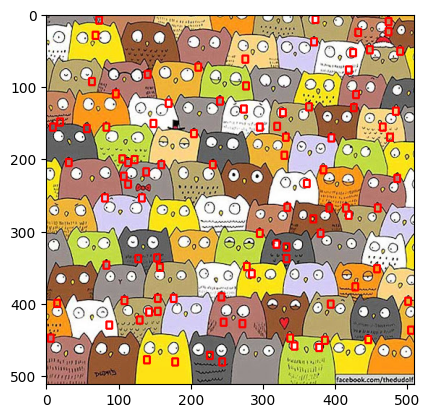

In [134]:
b = apply_templates(image_gray, [templates_gray[2]], image_rgb, selecting_threshold= -100,overlap_threshold=0.05)
len(b)

In [135]:
def test_bb(bb: list, image):
    """ 
    check random 5 bb"""
    res_image = image.copy()
    check_bb = random.sample(bb, 5)
    for box in check_bb:
        cv2.rectangle(res_image, box[:2], (box[0] + box[2], box[1] + box[3]), (0,0,255), 2)
    plt.imshow(res_image[:, :, ::-1])

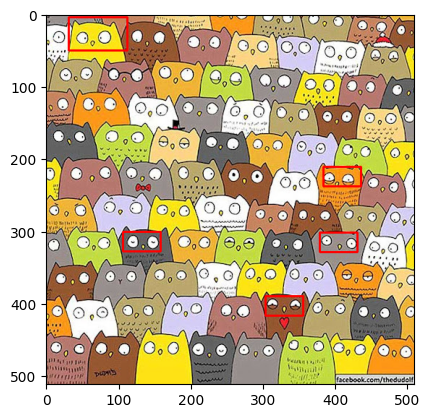

In [136]:
test_bb(a, image_rgb)

In [117]:
res = cv2.matchTemplate(image_gray, processed_template[0], cv2.TM_CCOEFF_NORMED)
res.shape, res.min(), res.max()

((467, 430), -0.2884042, 0.25688118)

In [118]:
threshold = sorted(res.flatten())[int(0.8 * len(res.flatten()))]
threshold

0.05601575

In [54]:
w, h = processed_template[0].shape[::-1]
loc = np.where(res >= threshold)
check = [] 
x, y = loc[::-1]  
for i in range(len(x)):
    score = res[y[i], x[i]]
    check.append((score, x[i], y[i], w, h))
check = sorted(check, key=lambda x: x[0], reverse=True)



In [55]:
check

[(0.25688118, 222, 159, 81, 46),
 (0.25436115, 223, 159, 81, 46),
 (0.25365046, 221, 159, 81, 46),
 (0.2519137, 222, 160, 81, 46),
 (0.25168163, 292, 383, 81, 46),
 (0.25031283, 222, 158, 81, 46),
 (0.24850455, 291, 383, 81, 46),
 (0.2483857, 221, 160, 81, 46),
 (0.24722701, 289, 382, 81, 46),
 (0.246989, 223, 158, 81, 46),
 (0.24656828, 221, 158, 81, 46),
 (0.24513207, 224, 159, 81, 46),
 (0.24390568, 223, 160, 81, 46),
 (0.24365331, 291, 384, 81, 46),
 (0.24252813, 220, 159, 81, 46),
 (0.24192429, 293, 383, 81, 46),
 (0.2415368, 290, 383, 81, 46),
 (0.24139881, 224, 158, 81, 46),
 (0.24129543, 290, 382, 81, 46),
 (0.2412346, 220, 160, 81, 46),
 (0.23854433, 292, 382, 81, 46),
 (0.23833781, 294, 383, 81, 46),
 (0.23804335, 291, 382, 81, 46),
 (0.23778115, 290, 384, 81, 46),
 (0.23753075, 227, 160, 81, 46),
 (0.23688391, 225, 160, 81, 46),
 (0.23642325, 224, 160, 81, 46),
 (0.23568653, 292, 384, 81, 46),
 (0.23534834, 226, 160, 81, 46),
 (0.23490602, 225, 159, 81, 46),
 (0.23412338, 22

In [56]:
bb_res = [] 
for i in range(len(check)):
    x1, y1, w1, h1 = check[i][1:]
    if len(bb_res) == 0:
        bb_res.append((x1, y1, w1, h1))
    else:
        flag = True
        for box in bb_res:
            if check_overlap(box, (x1, y1, w1, h1), overlap_threshold=0.3):
                flag = False
                break
        if flag:
            bb_res.append((x1, y1, w1, h1))
            
bb_res = [ele[:2] for ele in bb_res]

In [57]:
len(bb_res)

83

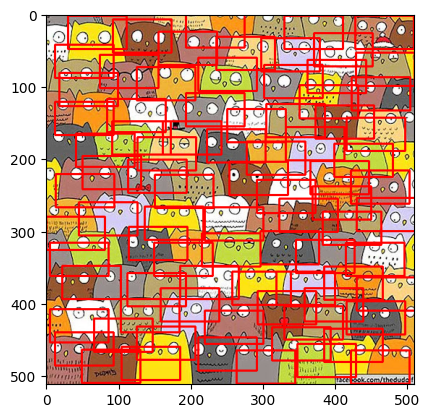

In [58]:
res_image = image_rgb.copy()
for bb in bb_res:
    cv2.rectangle(res_image, bb, (bb[0] + w, bb[1] + h), (0,0,255), 2)
    plt.imshow(res_image[:, :, ::-1])

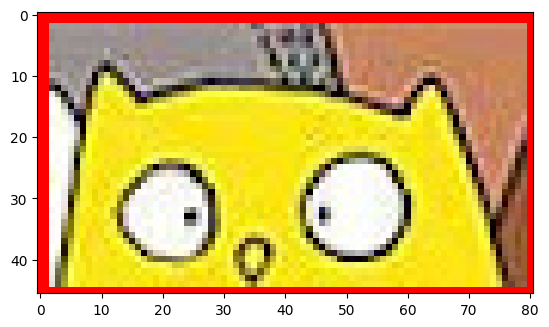

In [36]:
plt.imshow(res_image[0 : 0 + h,29: 29 + w][:, :, ::-1])